# Working with missing Data

In [2]:
import pandas as pd
mvc = pd.read_csv("data/nypd_mvc_2018.csv")
null_counts = mvc.isnull().sum()
null_counts

unique_key                 0
date                       0
time                       0
borough                20646
location                3885
on_street              13961
cross_street           29249
off_street             44093
pedestrians_injured        0
cyclist_injured            0
motorist_injured           0
total_injured              1
pedestrians_killed         0
cyclist_killed             0
motorist_killed            0
total_killed               5
vehicle_1                355
vehicle_2              12262
vehicle_3              54352
vehicle_4              57158
vehicle_5              57681
cause_vehicle_1          175
cause_vehicle_2         8692
cause_vehicle_3        54134
cause_vehicle_4        57111
cause_vehicle_5        57671
dtype: int64

To give us a better picture of the null values in the data, let's calculate the percentage of null values in each column. Below, we divide the number of null values in each column by the total number of values in the data set:

In [3]:
null_counts_pct = null_counts / mvc.shape[0] * 100
#We'll then add both the counts and percentages to a dataframe to make them easier to compare:
null_df = pd.DataFrame({'null_counts': null_counts, 'null_pct': null_counts_pct})
# Rotate the dataframe so that rows become columns and vice-versa
null_df = null_df.T.astype(float)
null_df

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
null_counts,0.0,0.0,0.0,20646.000000,3885.000000,13961.000000,29249.000000,44093.000000,0.0,0.0,...,355.000000,12262.000000,54352.000000,57158.000000,57681.000000,175.000000,8692.00000,54134.00000,57111.000000,57671.000000
null_pct,0.0,0.0,0.0,35.680216,6.714019,24.127264,50.547836,76.201092,0.0,0.0,...,0.613508,21.191069,93.930596,98.779898,99.683741,0.302433,15.02143,93.55385,98.698673,99.666459


<pre>About a third of the columns have no null values, with the rest ranging from less than 1% to 99%!
To make things easier, let's start by looking at the group of columns that relate to people killed in collisions.
We'll use list comprehension to reduce our summary dataframe to just those columns:</pre>

In [4]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
null_df[killed_cols]

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
null_counts,0.0,0.0,0.0,5.000000
null_pct,0.0,0.0,0.0,0.008641


Podemos ver que cada uma das categorias individuais não possui valores ausentes, mas a coluna total_killed possui cinco valores ausentes.

Uma opção para lidar com isso seria remover - ou excluir - essas cinco linhas. Essa seria uma opção razoavelmente válida, já que é uma pequena parte dos dados, mas vamos pensar em quais outras opções temos primeiro.

Se você pensar bem, o número total de pessoas mortas deve ser a soma de cada uma das categorias individuais. Poderemos "preencher" os valores ausentes com as somas das colunas individuais dessa linha. O nome técnico para preencher um valor ausente com um valor de substituição é chamado de *imputation*.

Vejamos como poderíamos explorar os valores em que total_killed não é igual à soma das outras três colunas. Ilustraremos esse processo usando uma série de diagramas. Os diagramas não conterão valores, apenas mostrarão uma grade para representar os valores.

We created a dataframe killed, containing the five columns that relate to people killed in collisions.

1. Select the first three columns from killed and sum each row. Assign the result to killed_manual_sum.
2. Create a boolean mask that checks whether each value in killed_manual_sum is not equal to the values in the total_killed column. Assign the boolean mask to killed_mask.
3. Use killed_mask to filter the rows in killed. Assign the result to killed_non_eq.

In [5]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

In [6]:
killed_manual_sum = killed.iloc[:,0:3].sum(axis=1)
killed_mask = killed_manual_sum != killed.total_killed
killed_non_eq = killed[killed_mask]
killed_non_eq

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
3508,0,0,0,NaN
20163,0,0,0,NaN
22046,0,0,1,0.0
48719,0,0,0,NaN
55148,0,0,0,NaN
55699,0,0,0,NaN


We can categorize these into two categories:

1. Five rows where the total_killed is not equal to the sum of the other columns because the total value is missing.
2. One row where the total_killed is less than the sum of the other columns.

From this, we can conclude that filling null values with the sum of the columns is a fairly good choice for our imputation, given that only six rows out of around 58,000 don't match this pattern.

 We've also identified a row that has suspicious data - one that doesn't sum correctly. Once we have imputed values for all rows with missing values for total_killed, we'll mark this suspect row by setting its value to NaN.

In order to execute this, we'll learn to use the Series.mask() method. Series.mask() is useful when you want to replace certain values in a series based off a boolean mask. The syntax for the method is:
```python
Series.mask(bool_mask, val_to_replace)
```
We included the code to clean the killed columns. In addition, we've created an injured dataframe with just the injured columns and injured_manual_sum, a series manually summing the three individual injured columns.

1. Use Series.mask() to replace any null values from the total_injured column with their equivalents from the injured_manual_sum series.
2. Use Series.mask() to replace any numbers from total_injured that aren't equal to their equivalents in injured_manual_sum with np.nan.

In [7]:
import numpy as np

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)

In [8]:
t = 'total_injured'
injured[t] = injured[t].mask(injured[t].isnull(), injured_manual_sum)
injured[t] = injured[t].mask(injured[t] != injured_manual_sum, np.nan)
injured.head()

,pedestrians_injured,cyclist_injured,motorist_injured,total_injured
0,0,0,0,0.0
1,0,0,0,0.0
2,0,0,1,1.0
3,0,0,0,0.0
4,0,0,0,0.0


In [9]:
summary = {
    'injured': [
        mvc['total_injured'].isnull().sum(),
        injured['total_injured'].isnull().sum()
    ],
    'killed': [
        mvc['total_killed'].isnull().sum(),
        killed['total_killed'].isnull().sum()
    ]
}
pd.DataFrame(summary, index=['before','after'])

,injured,killed
before,1,5
after,21,1


1. Assign the total_injured column from the injured dataframe to the same column in the mvc dataframe.
2. Assign the total_killed column from the killed dataframe to the same column in the mvc dataframe.

In [10]:
mvc['total_injured'] = injured['total_injured']
mvc['total_killed'] = killed['total_killed']

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
def plot_null_matrix(df, figsize=(10,6)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

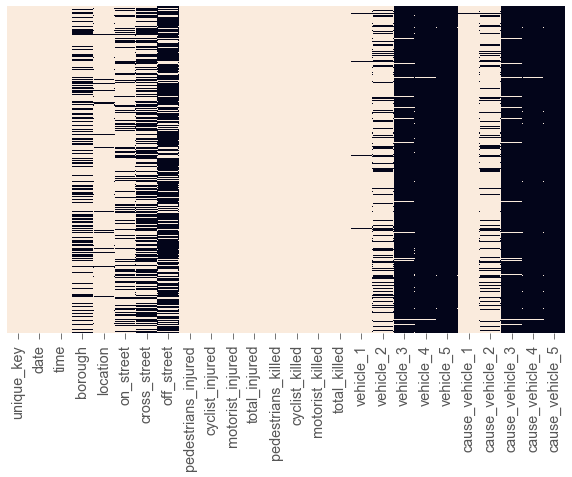

In [12]:
plot_null_matrix(mvc)

We can make some immediate interpretations about our dataframe:

- The first three columns have few to no missing values.
- The next five columns have missing values scattered throughout, with each column seeming to have its own density of missing values.
- The next eight columns are the injury and killed columns we just cleaned, and only have a few missing values.
- The last 10 columns seem to break into two groups of five, with each group of five having similar patterns of null/non-null values.

Let's examine the pattern in the last 10 columns a little more closely. We can calculate the relationship between two sets of columns, known as correlation. 
To calculate this we use the dataframe.corr() method (You'll learn more about correlation in a later course). Here's what that looks like:


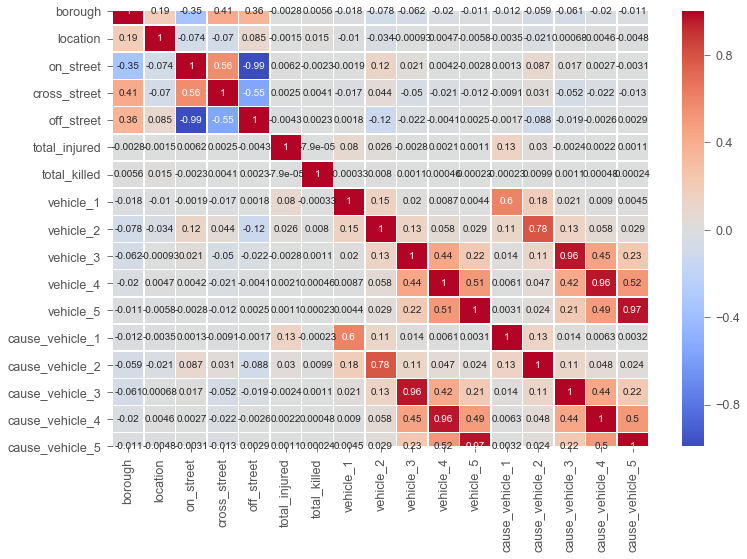

In [13]:
cols_with_missing_vals = mvc.columns[mvc.isnull().sum() > 0]
missing_corr = mvc[cols_with_missing_vals].isnull().corr()
plt.figure(figsize=(12,8))
sns.heatmap(missing_corr,annot=True,linewidth = 0.5, cmap='coolwarm')

1. Use list comprehension to produce a list of column names containing the substring 'vehicle'.
2.  the list of column names to select only those columns from the mvc dataframe. Pass the result to the plot_null_correlations() function.

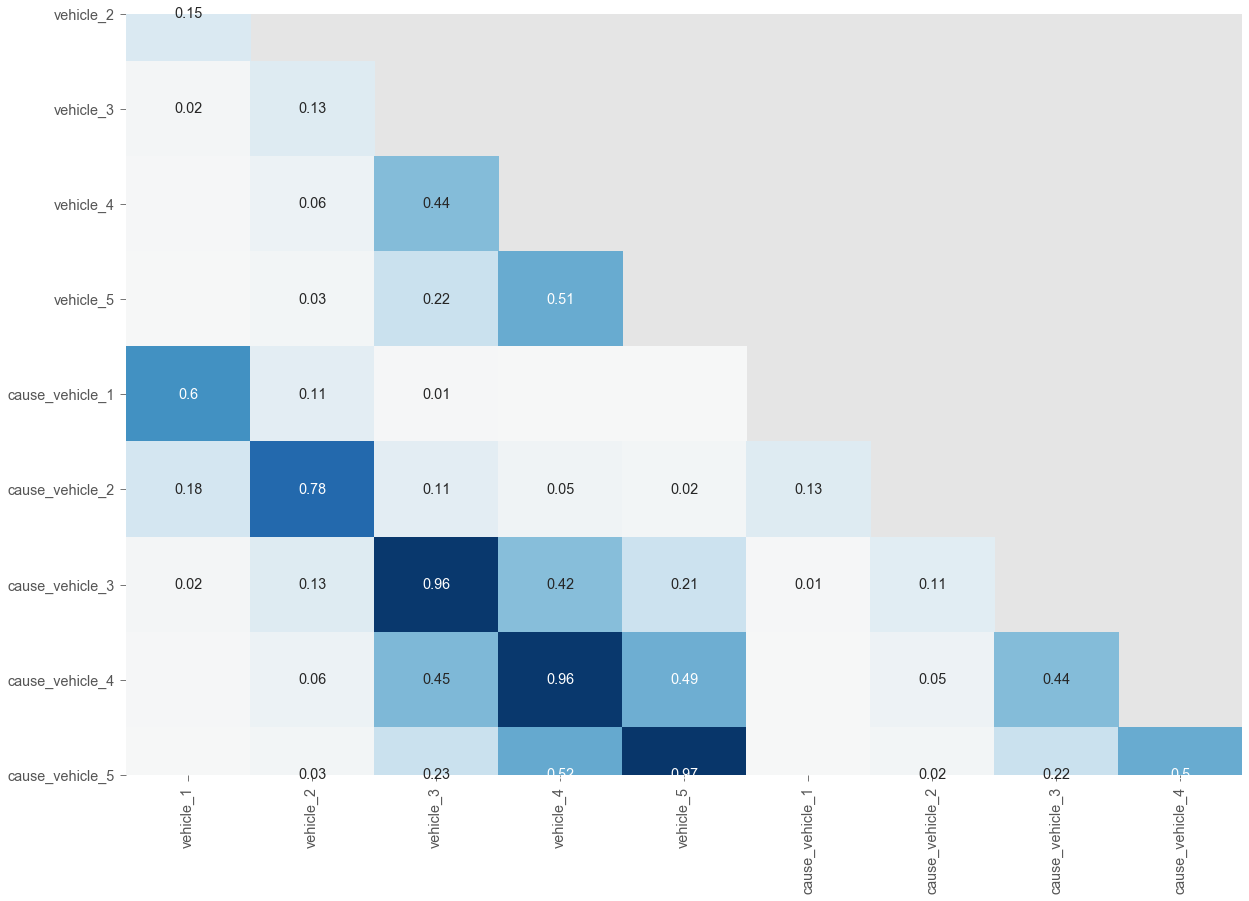

In [14]:
def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    
v_cols = [col for col in mvc.columns if 'vehicle' in col]
plot_null_correlations(mvc[v_cols])

We outlined a diagonal strip of five squares in green that have a higher correlation than the rest. The pairs of column names that make up these five correlations are:
<pre>
vehicle_1 and cause_vehicle_1
vehicle_2 and cause_vehicle_2
vehicle_3 and cause_vehicle_3
vehicle_4 and cause_vehicle_4
vehicle_5 and cause_vehicle_5
</pre>
If you think about it, this makes sense. When a vehicle is in an accident, there is likely to be a cause, and vice-versa.

Let's explore the variations in missing values from these five pairs of columns. We'll create a dataframe that counts, for each pair:

- The number of values where the vehicle is missing when the cause is not missing.
- The number of values where the cause is missing when the vehicle is not missing.
- The final structure of our dataframe will look like this:
<pre>
v_number	vehicle_missing	cause_missing
0	1	[count]	[count]
1	2	[count]	[count]
2	3	[count]	[count]
3	4	[count]	[count]
4	5	[count]	[count]
</pre>

We provided the start of the loop you are going to build, including code that generates each column name as strings: v_col and c_col

1. Uncomment the commented lines (you might want to use this keyboard shortcut).
    - Add code to the body of the loop that will:
        - Count the number of rows where the v_col column is null and the c_col column is not null. Assign the result to v_null.
        - Count the number of rows where the c_col column is null and the v_col column is not null. Assign the result to c_null.
        - Append an item to the vc_null_data list. The item should be a list containing, in order: v, v_null, c_null.
2. Outside the loop, create a dataframe using the vc_null_data list of lists.
    - Use the columns parameter and the col_labels list to set the column names of the dataframe.
    - Assign the dataframe to vc_null_df.

In [18]:
col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    v_null = mvc[(mvc[v_col].isnull() & mvc[c_col].notnull())].shape[0]
    c_null = mvc[(mvc[c_col].isnull() & mvc[v_col].notnull())].shape[0]
    vc_null_data.append([v,v_null, c_null])
    
vc_null_df = pd.DataFrame(data=vc_null_data, columns=col_labels)

A análise que fizemos na tela anterior indica que existem aproximadamente 4.500 valores ausentes nas 10 colunas. 
A opção mais fácil para lidar com isso seria descartar as linhas com valores ausentes. 
Isso significaria perder quase 10% do total de dados, o que idealmente queremos evitar.

Uma opção melhor é imputar os dados, como fizemos anteriormente. 
Como os dados nessas colunas são de texto, não podemos realizar um cálculo numérico para imputar os dados ausentes, como fizemos com as lesões e as colunas mortas.

Uma opção comum ao imputar é usar o valor mais comum para preencher dados. 
Vamos examinar os valores comuns nessas colunas e ver se podemos usá-lo para tomar uma decisão.

Anteriormente, usamos o método Series.value_counts () para encontrar os valores mais comuns em uma única coluna. Nesse caso, queremos encontrar os valores mais comuns em várias colunas. Para fazer isso, primeiro precisamos converter nosso quadro de dados de várias colunas em uma única coluna e, em seguida, podemos usar Series.value_counts () para contar os itens.

Para converter um quadro de dados em uma única coluna de valores, usamos o método DataFrame.stack (), que empilha um objeto de quadro de dados em um objeto de Série. Vejamos um diagrama de como isso funciona. Começaremos com um quadro de dados simples com três colunas contendo palavras:

<img src='images/stack_count_1.svg' />

<img src='images/stack_count_2.svg' />

Let's use this technique to count the most common values for the cause set of columns. We'll start by selecting only the columns containing the substring cause.

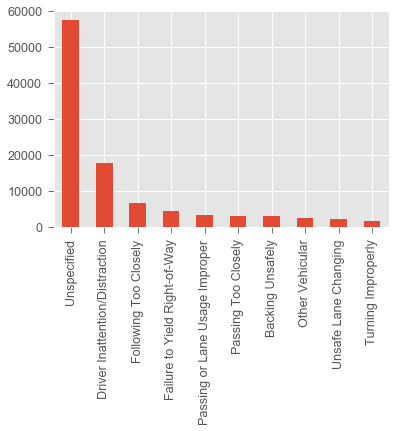

In [28]:
cause_cols = [c for c in mvc.columns if "cause_" in c]
cause = mvc[cause_cols]
#print(cause.head(2))
cause_1d = cause.stack()
#print(cause_1d.head(2))
cause_counts = cause_1d.value_counts()
top10_causes = cause_counts.head(10)
top10_causes.plot.bar()
plt.show()

1. Create a dataframe containing only the vehicle columns from mvc, identified by the list comprehension v_cols.
2. Use DataFrame.stack() to stack the values from the dataframe into a single series object.
3. Use Series.value_counts() to count the unique values from the stacked series. Assign the first 10 values to top10_vehicles.

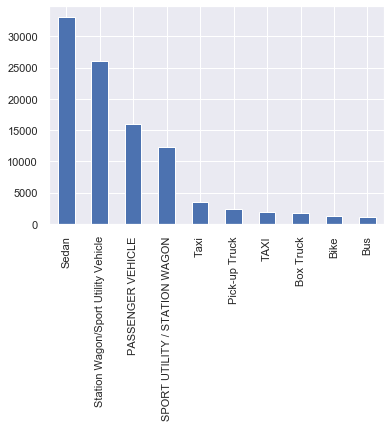

In [34]:
sns.set()
v_cols = [c for c in mvc.columns if c.startswith("vehicle")]
top10_vehicles = mvc[v_cols].stack().value_counts().head(10)
top10_vehicles.plot.bar()

We can use Series.mask() to replace the values, just like we did earlier in the mission. 
Let's look at code to perform this for the vehicle_1 and vehicle_cause_1 columns:


```python
# create a mask for each columnm
v_missing_mask = mvc['vehicle_1'].isnull() & mvc['cause_vehicle_1'].notnull()
c_missing_mask = mvc['cause_vehicle_1'].isnull() & mvc['vehicle_1'].notnull()

# replace the values matching the mask for each column
mvc['vehicle_1'] =  mvc['vehicle_1'].mask(v_missing_mask, "Unspecified")
mvc['cause_vehicle_1'] =  mvc['cause_vehicle_1'].mask
# create a mask for each column
v_missing_mask = mvc['vehicle_1'].isnull() & mvc['cause_vehicle_1'].notnull()
c_missing_mask = mvc['cause_vehicle_1'].isnull() & mvc['vehicle_1'].notnull()
​
# replace the values matching the mask for each column
mvc['vehicle_1'] =  mvc['vehicle_1'].mask(v_missing_mask, "Unspecified")
mvc['cause_vehicle_1'] =  mvc['cause_vehicle_1'].mask(c_missing_mask, "Unspecified")
```


1. Add code to the body of the loop that:
     - Creates a boolean mask for values where the vehicle column is null and the cause column is non-null.
    - Creates a boolean mask for values where the cause column is null and the vehicle column is non-null.
    - Uses the first boolean mask to fill matching values from the vehicle column with the string Unspecified.
    - Uses the second boolean mask to fill matching values from the cause column with the string Unspecified.
2. Outside the loop, use the summarize_missing() function to check that you have removed all matching values. Assign the result to summary_after.

In [35]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

summary_before = summarize_missing()

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull())
    c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull())
    mvc[v_col] = mvc[v_col].mask(v_missing,'Unspecified')
    mvc[c_col] = mvc[c_col].mask(c_missing,'Unspecified')
summary_after = summarize_missing()
summary_after

,vehicle_number,vehicle_missing,cause_missing
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0


We read the supplemental data into a dataframe called sup_data. Additionally, we provided a list of the location columns, location_cols, and calculated the number of null values in these columns.

1. Loop over the column names in location_cols. In each iteration of the loop, use Series.mask() to replace values in the column in the mvc dataframe:
2. The mask should represent whether the values in column in the mvc has a null value or not.
3. Where the mask is true, the value should be replaced with the equivalent value in sup_data.
4. Calculate the number of null values across the location_cols columns in mvc after you adding the supplemental data. Assign the result to null_after.

In [42]:
sup_data = pd.read_csv('data/supplemental_data.csv')

location_cols = ['location', 'on_street', 'off_street', 'borough']
null_before = mvc[location_cols].isnull().sum()
null_before

location       3885
on_street     13961
off_street    44093
borough       20646
dtype: int64

In [40]:
sup_data.head()

,unique_key,location,on_street,off_street,borough
0,3869058,NaN,NaN,NaN,NaN
1,3847947,NaN,NaN,NaN,NaN
2,3914294,NaN,BELT PARKWAY,NaN,BROOKLYN
3,3915069,NaN,NaN,NaN,NaN
4,3923123,NaN,NaN,NaN,NaN


In [44]:
for col in location_cols:
    isnull_value = mvc[col].isnull()
    mvc[col] = mvc[col].mask(isnull_value, sup_data[col])
null_after = mvc[location_cols].isnull().sum()
null_after

location         77
on_street     13734
off_street    36131
borough         232
dtype: int64